In [149]:
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.interpolate import interp1d
from sklearn.metrics import  roc_curve, auc,precision_recall_curve,f1_score, confusion_matrix

In [150]:
ensemble_lib = 'test'
gene="NPM1"
top_value = 3
desired_sensitivity = 0.75
file_path=f"/home/weber50432/AML-WSI/MIL/test/{gene}_cell/2000_cells/different_K"
output_path=f"/home/weber50432/AML-WSI/MIL/test/{gene}_cell/2000_cells/ensemble"

model_list= []
model_auc_list =[]

for model in os.listdir(file_path):
    model_path = os.path.join(file_path, model)
    if not os.path.exists(os.path.join(model_path, f"predictions_{ensemble_lib}.csv")):
        continue
    prediction_test = pd.read_csv(os.path.join(model_path, f"predictions_{ensemble_lib}.csv"))
    # calculate roc_auc
    fpr, tpr, thresholds = roc_curve(prediction_test['target'], prediction_test['probability'])
    roc_auc = auc(fpr, tpr)
    model_auc_list.append((model, roc_auc))

top_models = sorted(model_auc_list, key=lambda x: x[1], reverse=True)[:top_value]
model_list = [model[0] for model in top_models]  # 只取模型名稱

# print(model_list)

In [151]:
loss_list = []
pred_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
for i in model_list:
    loaded_obj = torch.load(f"{file_path}/{i}/checkpoint_best.pth", map_location=torch.device('cpu'))
    loss_list.append(loaded_obj['best_acc'])
    pred_list.append(pd.read_csv(f"{file_path}/{i}/predictions_{ensemble_lib}.csv"))
# print(pred_list)

In [152]:
weights_list= []
for i in loss_list:
  weights_list.append(np.exp(i))
weights_list=np.array(weights_list)
weights_list/=np.sum(weights_list)
print(weights_list)

[0.34295824 0.32532703 0.33171473]


In [153]:
# add the probability columns of the two models, and make the average. store to a new df
df_avg = pd.DataFrame()
df_avg['file'] = pred_list[0]['file']
df_avg['target'] =pred_list[0]['target']
df_avg['probability'] = 0

In [154]:
for index, i in enumerate(pred_list):
    df_avg['probability'] = df_avg['probability'] + i['probability']*weights_list[index]
# if the average probability is larger than 0.5, then the prediction is 1, otherwise 0
df_avg['prediction'] = df_avg['probability'].apply(lambda x: 1 if x > 0.5 else 0)
# switche the order of the columns, probability is the last column
df_avg = df_avg[['file', 'target', 'prediction', 'probability']]
df_avg.to_csv(f'{output_path}/predictions_ensemble_{ensemble_lib}.csv', index=False)

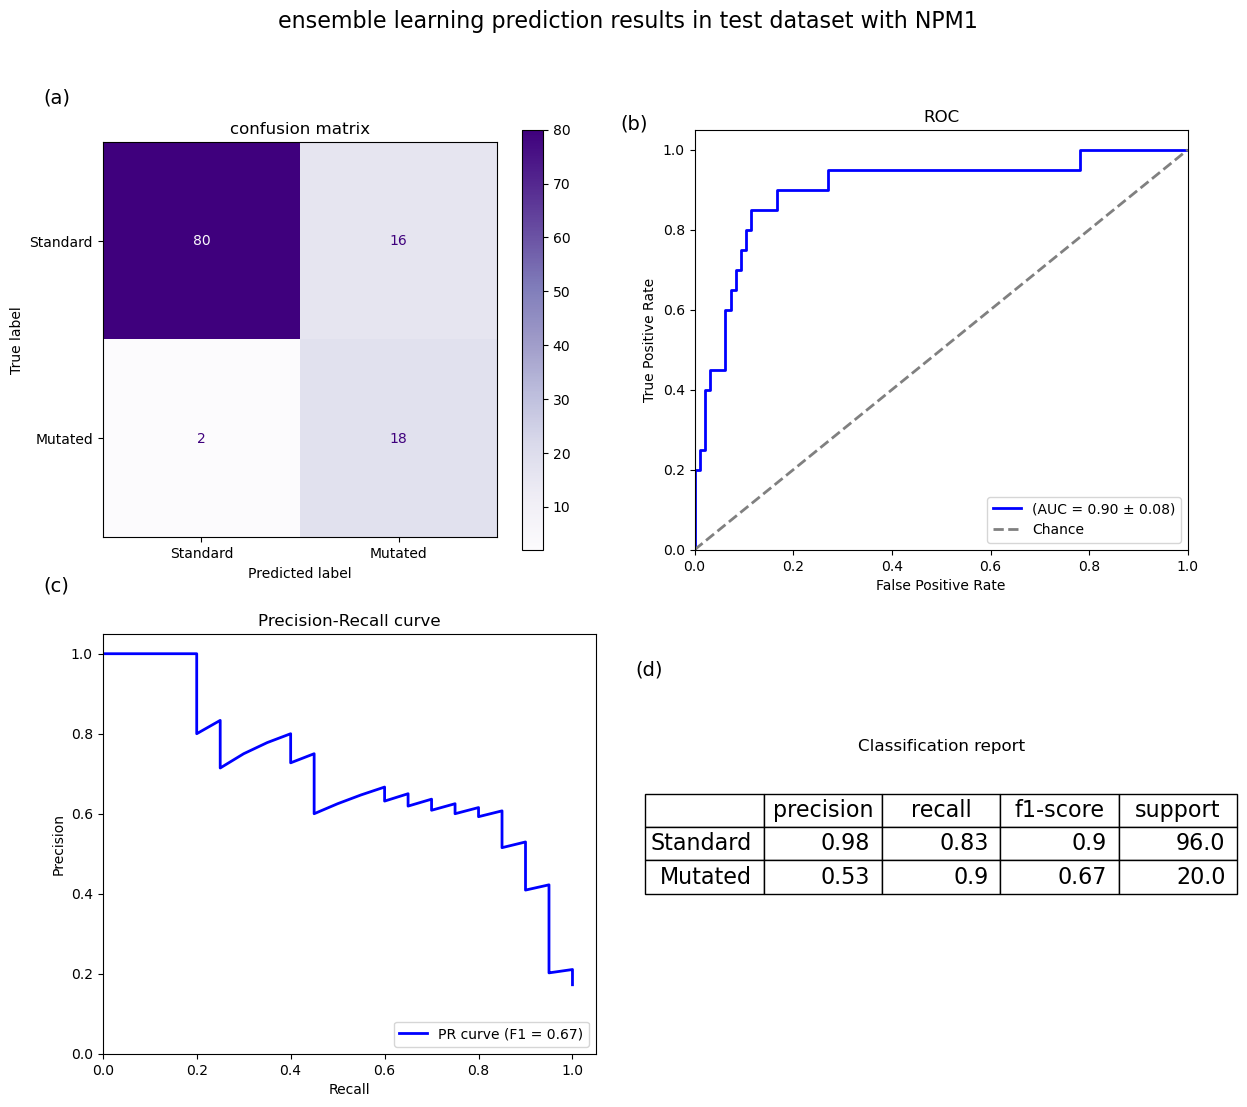

In [159]:
# Get the true labels and predicted labels
y_true = df_avg['target']
predicted_probabilities = df_avg["probability"]  # Replace with your predicted probabilities
true_labels = df_avg["target"]  # Replace with your true labels

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.001)
best_threshold = None
best_f1 = 0.0
best_cm = None
report = None
# Iterate over each threshold value
for threshold in thresholds:
    # Convert probabilities to predicted labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    # Calculate the desired  F1 score
    temp_f1 = f1_score(true_labels, predicted_labels)
    temp_report = metrics.classification_report(y_true, predicted_labels, output_dict=True)
    
    # Update the best threshold and temp_f1 if necessary
    if temp_f1 > best_f1:
        best_cm = cm
        best_threshold = threshold
        best_f1 =temp_f1 
        report = temp_report

# Calculate the 95% Confidence Interval for AUC (using the Bootstrap method)
n_bootstraps = 1000
rng_seed = 42
bootstrapped_aucs = []
rng = np.random.RandomState(rng_seed)

for _ in range(n_bootstraps):
    indices = rng.randint(0, len(predicted_probabilities), len(predicted_probabilities))
    
    if len(np.unique(true_labels.values[indices])) < 2:
        continue
    
    score = auc(*roc_curve(true_labels.values[indices],
                           predicted_probabilities.values[indices])[:2])
    bootstrapped_aucs.append(score)

sorted_scores = np.array(bootstrapped_aucs)
sorted_scores.sort()
ci_lower = sorted_scores[int(0.025 * len(sorted_scores))]
ci_upper = sorted_scores[int(0.975 * len(sorted_scores))]
ci_radius = (ci_upper - ci_lower) / 2
ci_center = (ci_upper + ci_lower) / 2  

# Compute the false positive rate, true positive rate and thresholds for the ROC curve
fpr, tpr, best_threshold = roc_curve(y_true, predicted_probabilities)
# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)
# show the accuracy, precision, recall and f1-score
# print(metrics.classification_report(y_true, y_pred))
# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle(f'ensemble learning prediction results in {ensemble_lib} dataset with {gene}', fontsize=16)

# Plot the confusion matrix in the first subplot
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = best_cm, display_labels = ['Standard','Mutated'] )
cm_display.plot(ax=axs[0][0], cmap=plt.cm.Purples)
axs[0][0].set_title('confusion matrix')
axs[0][0].text(-0.15, 1.1, '(a)', transform=axs[0][0].transAxes, size=14)

# Plot the ROC curve in the second subplot
axs[0][1].plot(fpr, tpr, color='blue', lw=2, label=f'(AUC = {roc_auc:.2f} ± {ci_radius:.2f})')
# axs[0][1].fill_between(fpr, tpr - ci_radius, tpr + ci_radius, color='blue', alpha=0.2,
#                        label=f'95% CI [{ci_lower:.2f}, {ci_upper:.2f}]')
axs[0][1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label= 'Chance')
axs[0][1].set_xlim([0.0, 1.0])
axs[0][1].set_ylim([0.0, 1.05])
axs[0][1].set_xlabel('False Positive Rate')
axs[0][1].set_ylabel('True Positive Rate')
axs[0][1].set_title('ROC')
axs[0][1].legend(loc="lower right")
axs[0][1].text(-0.15, 1, '(b)', transform=axs[0][1].transAxes, size=14)

# Plot the precision-recall curve in the third subplot
precision, recall, thresholds = precision_recall_curve(y_true, predicted_probabilities)
f1 = best_f1
axs[1][0].plot(recall, precision, color='blue', lw=2, label='PR curve (F1 = %0.2f)' % f1)
axs[1][0].set_xlim([0.0, 1.05])
axs[1][0].set_ylim([0.0, 1.05])
axs[1][0].set_xlabel('Recall')
axs[1][0].set_ylabel('Precision')
axs[1][0].text(-0.12, 1.1, '(c)', transform=axs[1][0].transAxes, size=14)
axs[1][0].legend(loc="lower right")
axs[1][0].set_title('Precision-Recall curve')
# show the accuracy, precision, recall and f1-score in a table form at the fourth subplot

df_report = pd.DataFrame(report).transpose()
df_report.reset_index(drop=False, inplace=True)
df_report.rename(columns={'index':''}, inplace=True)
df_report.replace(to_replace="1", value='Mutated', inplace=True)
df_report.replace(to_replace="0", value='Standard', inplace=True)
accuracy = metrics.accuracy_score(y_true, predicted_labels)
# print(f'Accuracy: {accuracy:.2f}')
fpr_interp = interp1d(tpr, fpr)
desired_fpr = fpr_interp(desired_sensitivity)

# remove the last three rows
df_report.drop(df_report.tail(3).index, inplace=True)
df_report = df_report.round(2)

axs[1][1].text(-0.12,0.9, '(d)', transform=axs[1][1].transAxes, size=14)
axs[1][1].axis('tight')
axs[1][1].axis('off')
axs[1][1].set_title('Classification report', y=0.8,pad=-24)
# add the table
the_table = axs[1][1].table(cellText=df_report.values, colLabels=df_report.columns ,loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(1.2, 2)

# Show the plot
plt.show()

NPM1_densenet121_K24: FPR = 0.09, TPR = 0.75


NPM1_densenet121_K29: FPR = 0.24, TPR = 0.75
NPM1_densenet121_K26: FPR = 0.16, TPR = 0.75


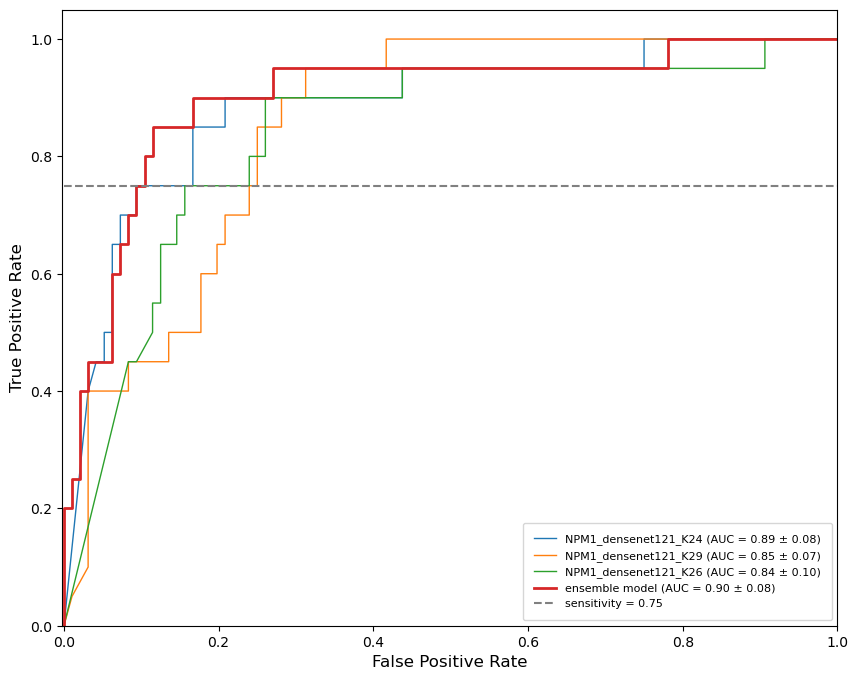

In [158]:
plt.figure(figsize=(10, 8))  # Set figure size

for i, model in enumerate(model_list):
    df = pd.read_csv(f"{file_path}/{model}/predictions_{ensemble_lib}.csv")

    fpr, tpr, thresholds = roc_curve(df['target'], df['probability'])
    roc_auc = auc(fpr, tpr)

    best_threshold = None
    best_f1 = 0.0
    for threshold in thresholds:
        predicted_labels = (df['probability'] >= threshold).astype(int)
        f1 = f1_score(df['target'], predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    closest_idx = np.abs(desired_sensitivity -tpr).argmin()
    closest_fpr = fpr[closest_idx]
    closest_tpr = tpr[closest_idx]
    print(f'{model_list[i]}: FPR = {closest_fpr:.2f}, TPR = {closest_tpr:.2f}')

    n_bootstraps = 1000
    rng_seed = 42
    bootstrapped_aucs = []
    rng = np.random.RandomState(rng_seed)
    for _ in range(n_bootstraps):
        indices = rng.randint(
            0, len(df['probability']), len(df['probability']))
        if len(np.unique(df['target'].values[indices])) < 2:
            continue
        score = auc(*roc_curve(df['target'].values[indices],
                    df['probability'].values[indices])[:2])
        bootstrapped_aucs.append(score)
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    ci_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    ci_upper = sorted_scores[int(0.975 * len(sorted_scores))]

    ci_radius = (ci_upper - ci_lower) / 2
    ci_center = (ci_upper + ci_lower) / 2  

    plt.plot(fpr, tpr, lw=1,label=f'{model_list[i]} (AUC = {roc_auc:.2f} ± {ci_radius:.2f})')
        
    # 在曲線上標記該點
    # plt.scatter(closest_fpr, closest_tpr,color=model_color[i],  zorder=4)
    # plt.text(closest_fpr, closest_tpr,
    #          f'{closest_fpr:.2f}', fontsize=8, color=model_color[i])

#Plot ensemble model
fpr, tpr, _ = roc_curve(df_avg['target'], df_avg['probability'])
roc_auc = auc(fpr, tpr)
fpr_interp = interp1d(tpr, fpr)
desired_fpr = fpr_interp(desired_sensitivity)
n_bootstraps = 1000
rng_seed = 42
bootstrapped_aucs = []
rng = np.random.RandomState(rng_seed)
for _ in range(n_bootstraps):
    indices = rng.randint(
        0, len(df_avg['probability']), len(df_avg['probability']))
    if len(np.unique(df_avg['target'].values[indices])) < 2:
        continue
    score = auc(*roc_curve(df_avg['target'].values[indices],
                df_avg['probability'].values[indices])[:2])
    bootstrapped_aucs.append(score)
sorted_scores = np.array(bootstrapped_aucs)
sorted_scores.sort()
ci_lower = sorted_scores[int(0.025 * len(sorted_scores))]
ci_upper = sorted_scores[int(0.975 * len(sorted_scores))]

ci_radius = (ci_upper - ci_lower) / 2
ci_center = (ci_upper + ci_lower) / 2  

plt.plot(fpr, tpr, lw=2,label=f'ensemble model (AUC = {roc_auc:.2f} ± {ci_radius:.2f})')


plt.plot([0, 1], [desired_sensitivity, desired_sensitivity],
         color='gray', linestyle='--', label='sensitivity = 0.75')
plt.xlim([-0.002, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=8, borderpad=1)
plt.show()